In [2]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import tensorflow.keras.utils
from sklearn.model_selection import train_test_split

### Loading Data

In [3]:
absFolder=os.getcwd()
parentFolder = os.path.dirname(absFolder)
dataFolder = os.path.join(parentFolder, 'Data')
allImagesFolder = os.path.join(dataFolder, 'all')

allImagesFolder = '/Users/jessemaccormac/Documents/QMIND/pothole-vid-2020-01-29-JM-1'

In [4]:
labels = []

for filename in os.listdir(allImagesFolder):
    if filename.endswith(".xml"):
        filepath = os.path.join(allImagesFolder, filename)
        xml = ET.parse(filepath)
        annot = xml.getroot()
        fName = annot.find('filename').text
        size = annot.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        if width<40 or height<40 or width >999999 or height> 999999:
            continue
        
        objects = annot.findall('object')
        if len(objects)!=1:
            pass
        elif objects[0].find('name').text=='pothole':
            box = objects[0].find('bndbox')
            
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
            
            if xmin<0 or xmax>width or ymin<0 or ymax>height:
                continue
            
            labels.append([fName, width, height, "pothole", xmin, ymin, xmax, ymax])

labelDf = pd.DataFrame(labels, 
                       columns=["filename", "width", 'height', "class", 'xmin', 'ymin', 'xmax', 'ymax'])

In [5]:
labelDf.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,pothole-0068.jpg,1920,1080,pothole,722,398,1602,632
1,pothole-0040.jpg,1920,1080,pothole,689,500,1509,732
2,pothole-0054.jpg,1920,1080,pothole,600,387,1465,624
3,pothole-0083.jpg,1920,1080,pothole,833,478,1748,682
4,pothole-0097.jpg,1920,1080,pothole,666,504,1594,715
5,pothole-0242.jpg,1920,1080,pothole,657,469,1572,665
6,pothole-0256.jpg,1920,1080,pothole,781,430,1688,643
7,pothole-0281.jpg,1920,1080,pothole,588,501,1363,829
8,pothole-0295.jpg,1920,1080,pothole,555,465,1368,818
9,pothole-0336.jpg,1920,1080,pothole,519,241,1317,512


### Split images into labeled segments

In [6]:
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [7]:
def overlap(l1, r1, l2, r2):
    if(l1[0] > r2[0] or l2[0] > r1[0]): 
        return False
    if(l1[1] > r2[1] or l2[1] > r1[1]):
        return False
    return True

In [ ]:
# Adjust window dimensions and step size
(winW, winH) = (960, 360)
stepSize = 128

In [8]:
labels=[]

newsize = (128, 128)

for index, row in labelDf.iterrows():
    fPath = os.path.join(allImagesFolder, row['filename'])
#     fPath = '/Users/jessemaccormac/Documents/QMIND/pothole-vid-2020-01-29-JM-1/pothole-0000.jpg'
    image = cv2.imread(fPath)
    for (sliding_x, sliding_y, window) in sliding_window(image, stepSize, windowSize=(winW, winH)):
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        intersection_x1 = max(row['xmin'], sliding_x)
        intersection_y1 = max(row['ymin'], sliding_y)
        intersection_x2 = min(row['xmax'], sliding_x+winW)
        intersection_y2 = min(row['ymax'], sliding_y+winH)

        sliding_image = image[sliding_y:sliding_y+winH, sliding_x:sliding_x+winW]
        sliding_image = cv2.resize(sliding_image, newsize)
        
        if (overlap((row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (sliding_x, sliding_y), (sliding_x+winW, sliding_y+winH))):
            interArea = max(0, intersection_x2 - intersection_x1 + 1) * max(0, intersection_y2 - intersection_y1 + 1)

            potholeArea = (row['xmax'] - row['xmin'] + 1) * (row['ymax'] - row['ymin'] + 1)

            if(interArea > (potholeArea/3)):
                labels.append([np.asarray(sliding_image), 1])
            else:
                labels.append([np.asarray(sliding_image), 0])
        else:
            labels.append([np.asarray(sliding_image), 0])

df = pd.DataFrame(labels, columns=["image","class"])            

In [9]:
X = np.array(df.image.tolist())
Y = df[['class']].to_numpy()

In [10]:
print(X.shape)
print(Y.shape)

(17328, 128, 128, 3)
(17328, 1)


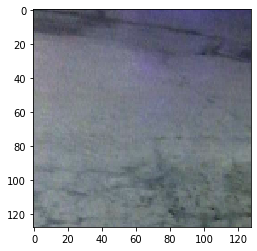

In [11]:
plt.figure()
plt.imshow(X[1])
plt.grid(False)
plt.show()

/Users/jessemaccormac/opt/anaconda3/envs/robo_traverse/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


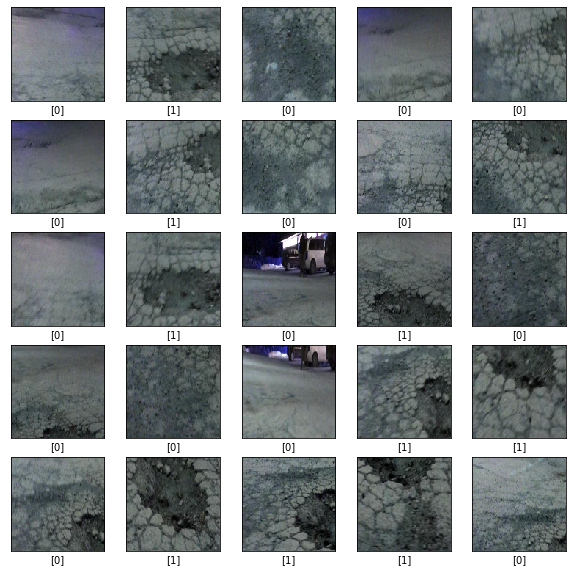

In [43]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i*20], cmap=plt.cm.binary)
    plt.xlabel(Y[i*20])
plt.show()

### Model Design

In [44]:
model = Sequential([
#     Conv2D(16, (2,2), input_shape=(128, 128, 3), activation='relu')
    Conv2D(16, (3,3), activation = 'relu', input_shape =(128,128,3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [46]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [47]:
train_images, test_images, train_labels, test_labels = train_test_split(X,Y,test_size=0.2, shuffle = True)

In [48]:
model.fit(train_images, train_labels, validation_data=[test_images, test_labels], epochs=30)

Train on 13862 samples, validate on 3466 samples
Epoch 1/30
13862/13862 [==============================] - 47s 3ms/sample - loss: 0.8944 - accuracy: 0.8362 - val_loss: 0.1749 - val_accuracy: 0.9316
Epoch 2/30
13862/13862 [==============================] - 46s 3ms/sample - loss: 0.1575 - accuracy: 0.9392 - val_loss: 0.2399 - val_accuracy: 0.9224
Epoch 3/30
13862/13862 [==============================] - 45s 3ms/sample - loss: 0.1238 - accuracy: 0.9551 - val_loss: 0.2871 - val_accuracy: 0.9143
Epoch 4/30
13862/13862 [==============================] - 45s 3ms/sample - loss: 0.1000 - accuracy: 0.9636 - val_loss: 0.0965 - val_accuracy: 0.9636
Epoch 5/30
13862/13862 [==============================] - 45s 3ms/sample - loss: 0.0821 - accuracy: 0.9704 - val_loss: 0.1583 - val_accuracy: 0.9423
Epoch 6/30
13862/13862 [==============================] - 45s 3ms/sample - loss: 0.0790 - accuracy: 0.9724 - val_loss: 0.2127 - val_accuracy: 0.9420
Epoch 7/30
13862/13862 [==============================] -

In [49]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

3466/1 - 4s - loss: 0.0871 - accuracy: 0.9711

Test accuracy: 0.9711483


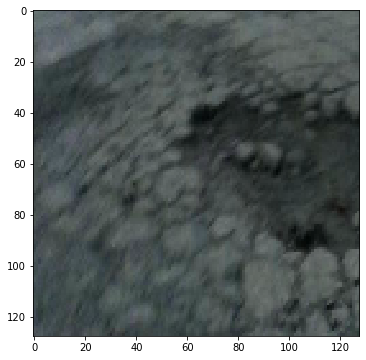

In [50]:
# class_idx = 0
# indices = np.where(val_y[:, class_idx] == 1.)[0]

# pick some random input from here
idx = 20

# check picked image

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(test_images[idx][...])